In [13]:
import warnings
warnings.filterwarnings(action= "ignore")

from cesium import datasets
from cesium import featurize

import numpy as np
import time

import matplotlib.pyplot as plt

#### EEG(Electroencephalogram, 원시 뇌전도) 데이터셋

In [2]:
eeg = datasets.fetch_andrzejak()

Loaded data from cached archive.


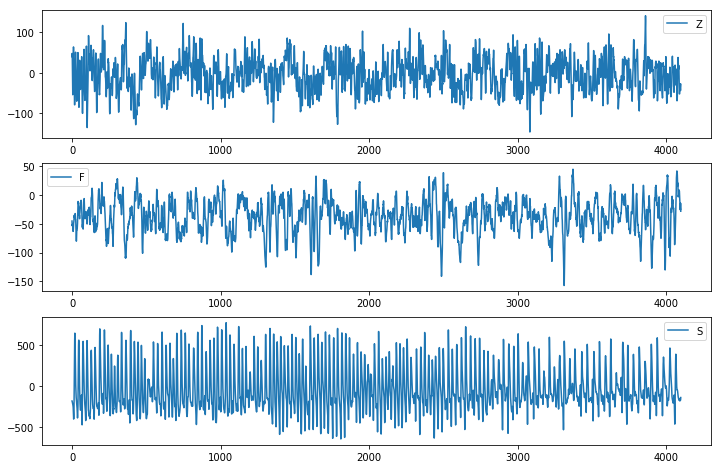

In [3]:
plt.figure(figsize= (12, 8))

plt.subplot(3, 1, 1)
plt.plot(eeg["measurements"][0])
plt.legend(eeg["classes"][0])

plt.subplot(3, 1, 2)
plt.plot(eeg["measurements"][300])
plt.legend(eeg["classes"][300])

plt.subplot(3, 1, 3)
plt.plot(eeg["measurements"][450])
plt.legend(eeg["classes"][450])

In [4]:
featurize_to_use = [
    "amplitude",
    "percent_beyond_1_std",
    "percent_close_to_median",
    "skew",
    "max_slope"
]

fset_cesium = featurize.featurize_time_series(
    times = eeg["times"],
    values = eeg["measurements"],
    errors = None,
    features_to_use = featurize_to_use,
    scheduler = None
)

In [5]:
fset_cesium.head()

feature,amplitude,percent_beyond_1_std,percent_close_to_median,skew,max_slope
channel,0,0,0,0,0
0,143.5,0.327313,0.505004,0.032805,11107.796610
1,211.5,0.290212,0.640469,-0.092715,20653.559322
2,165.0,0.302660,0.515987,-0.004100,13537.627119
3,171.5,0.300952,0.541128,0.063678,17008.813559
4,170.0,0.305101,0.566268,0.142753,13016.949153


In [6]:
std = np.std(eeg["measurements"][0])
mean = np.mean(eeg["measurements"][0])
print("std :", std)
print("mean :", mean)

sample_ts = eeg["measurements"][0]
sz = len(sample_ts)
ll = mean - std
ul = mean + std

quals = [i for i in range(sz) if sample_ts[i] < ll or sample_ts[i] > ul]
print(len(quals) / sz)

std : 40.41100040099819
mean : -4.1320478398828415
0.3273126678057115


#### 랜덤포레스트

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    fset_cesium.values,
    eeg["classes"],
    random_state= 21
)

In [9]:
rf_clf = RandomForestClassifier(
    n_estimators= 10,
    max_depth= 3,
    random_state= 21
)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=10, random_state=21)

In [10]:
rf_clf.score(X_test, y_test)

0.616

#### XGBoost

In [11]:
import xgboost as xgb

In [12]:
xgb_clf = xgb.XGBClassifier(
    n_estimators = 10,
    max_depth = 3,
    random_state = 21
)
xgb_clf.fit(X_train, y_train)
xgb_clf.score(X_test, y_test)

[11:08:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.688

In [15]:
start = time.time()
rf_clf.fit(X_train, y_train)
end = time.time()
print("RandomForest :", end - start)

RandomForest : 0.018619537353515625


In [16]:
start = time.time()
xgb_clf.fit(X_train, y_train)
end = time.time()
print("XGBoost :", end - start)

[11:10:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost : 2.963303565979004
